In [1]:
import sys
from pathlib import Path
import importlib.util
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi

# notebooks/.. = project_root
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


package_dir = project_root / "scdb_code_map"
init_file = package_dir / "__init__.py"
init_file.touch(exist_ok=True)  # creates empty __init__.py if missing


spec = importlib.util.find_spec("scdb_code_map")
if spec is None:
    raise ImportError(f"Cannot find 'scdb_code_map' in {project_root}")


from scdb_code_map import JUSTICE_NAME_MAP, ISSUE_AREA_MAP

In [2]:
conn = sqlite3.connect("../data/legal_sc.db")
c_citations = pd.read_sql("SELECT * FROM c_citations", conn)
conn.close()
#print(c_citations.columns.tolist())

In [3]:
# want to know authorship and workload distribution among the justice
# over time or as a function of issue area or based on who the chief justice is at the time
# Take a quick look at relevant columns

print(c_citations["majOpinWriter"].head())
print()
# print(c_citations["majOpinAssigner"].head())
# print()
# print(c_citations["chief"].head())

0    78.0
1    81.0
2    84.0
3    87.0
4    78.0
Name: majOpinWriter, dtype: float64



In [4]:
# Need to map Justice ID to names

c_citations["majOpinWriterName"] = (
    c_citations["majOpinWriter"].map(JUSTICE_NAME_MAP).fillna("Unknown"))

c_citations["majOpinAssignerName"] = (
    c_citations["majOpinAssigner"].map(JUSTICE_NAME_MAP).fillna("Unknown"))


In [5]:
# Opinion writing by workload, or who wrote how many opinions

authorship_by_justice = (
    c_citations
    .groupby("majOpinWriterName")
    .agg(num_opinions=("caseId", "count"))
    .sort_values("num_opinions", ascending=False)
)

print(authorship_by_justice, '\n')

# check total # of opinions written sum up to the total number of uniqe cases 9341 as every case should have an opinion writer
print(f"total cases: {authorship_by_justice["num_opinions"].sum()}")

                    num_opinions
majOpinWriterName               
Unknown                     1763
White, Byron                 475
Rehnquist, William           456
Brennan, William             454
Stevens, John                397
Douglas, William             368
Marshall, Thurgood           322
Stewart, Potter              314
Blackmun, Harry              314
Black, Hugo                  311
O'Connor, Sandra             300
Scalia, Antonin              282
Kennedy, Anthony             276
Thomas, Clarence             259
Burger, Warren               258
Powell, Lewis                254
Breyer, Stephen              218
Clark, Tom                   216
Ginsburg, Ruth               214
Harlan, John                 171
Warren, Earl                 170
Souter, David                158
Frankfurter, Felix           153
Roberts, John                144
Alito, Samuel                133
Sotomayor, Sonia             108
Reed, Stanley                105
Kagan, Elena                 102
Jackson, R

In [6]:
# Even after mapping, lots of opinion writer's name is unknown
# check what's the orginal value in the raw table
# Looks like lots of NaN value

unknown_ids = set(c_citations["majOpinWriter"]) - set(JUSTICE_NAME_MAP.keys())
len(unknown_ids), sorted(list(unknown_ids))[:20]
c_citations["majOpinWriter"].value_counts(dropna=False).head(10)

majOpinWriter
NaN      1763
95.0      475
102.0     456
92.0      454
103.0     397
81.0      368
98.0      322
100.0     314
94.0      314
78.0      311
Name: count, dtype: int64

In [7]:
# opinion writing workload by issue area, which justice write more opinions in which area


c_citations["issueAreaText"] = c_citations["issueArea"].map(ISSUE_AREA_MAP).fillna("Unknown")

authorship_by_issue = (
    c_citations
    .groupby(["issueAreaText", "majOpinWriterName"])
    .agg(num_opinions=("caseId", "count"))
    .reset_index()
)

# Sort by issue and num_opinions descending
authorship_by_issue = authorship_by_issue.sort_values(
    ["issueAreaText", "num_opinions"], 
    ascending=[True, False]
)

# filter out unknown or nan even though unknown is always the 'author' who wrote the most opinions
# but it gives no useful info
filtered_authorship_by_issue = authorship_by_issue[
    authorship_by_issue["majOpinWriterName"].notna()  # remove NaN
    & (authorship_by_issue["majOpinWriterName"] != "Unknown")  # remove "Unknown"
]

# Get top 5 for each issue
top_writer_by_issue = (
    filtered_authorship_by_issue
    .groupby("issueAreaText")
    .head(3)  # takes top x rows per group
)

# # These two options will force print the entire table
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
print(top_writer_by_issue)

top_writer_by_issue = top_writer_by_issue.rename(columns={'issueAreaText': 'issueArea'})

dfi.export(
    top_writer_by_issue.style.hide(axis='index'), 
    '../results/tbl_top_majOpinWriters_by_issue.jpg', 
    table_conversion='matplotlib'
)

            issueAreaText   majOpinWriterName  num_opinions
14              Attorneys       Powell, Lewis             8
17              Attorneys     Scalia, Antonin             7
19              Attorneys       Stevens, John             7
30           Civil Rights    Brennan, William            88
65           Civil Rights        White, Byron            86
53           Civil Rights  Rehnquist, William            83
94     Criminal Procedure  Rehnquist, William           158
106    Criminal Procedure        White, Byron           110
101    Criminal Procedure     Stewart, Potter            98
132           Due Process  Rehnquist, William            33
138           Due Process       Stevens, John            24
144           Due Process        White, Byron            23
154     Economic Activity    Douglas, William           135
178     Economic Activity       Stevens, John            93
147     Economic Activity         Black, Hugo            88
188      Federal Taxation     Blackmun, 

In [8]:
# opinion writing workload trends over time (term/year)

authorship_over_time = (
    c_citations
    .groupby(["term", "majOpinWriterName"])
    .size()
    .unstack(fill_value=0)
)

# # Don't print the table directly as it's very sparse with many 0 because many justics are not writing opinions in a given year
# print(authorship_over_time)

# Keep only justices who wrote at least N opinions over all terms
authorship_over_time_filtered = authorship_over_time.loc[:, (authorship_over_time.sum() > 200)]
authorship_over_time_filtered = authorship_over_time_filtered[authorship_over_time_filtered.sum(axis=1) > 10]

# still a very hard table to read after filtering
#print(authorship_over_time_filtered.head())

In [9]:
# or instead of keeping all columns, show only the top 2-3 opinion writers per term
# nlargest(3) keeps the 3 justices with the most opinions per term.
# also hard to read
# print()
top_authors_per_term = authorship_over_time.apply(lambda row: row.nlargest(3), axis=1)
# print(top_authors_per_term.head())

In [10]:
# Instead of trying to follow all the justice name and see how many opinions each wrote in a given year
# It's more meaningful to just track one or few justices of interest

# List of justices to focus on
justice_names = ["Roberts, John", "Rehnquist, William"]

# Select only those justices
selected_justices = authorship_over_time[justice_names]

# Remove terms where all selected justices wrote zero opinions
selected_nonzero = selected_justices[(selected_justices != 0).any(axis=1)]

print(selected_nonzero.head())

majOpinWriterName  Roberts, John  Rehnquist, William
term                                                
1971                           0                  11
1972                           0                  16
1973                           0                  17
1974                           0                  15
1975                           0                  16


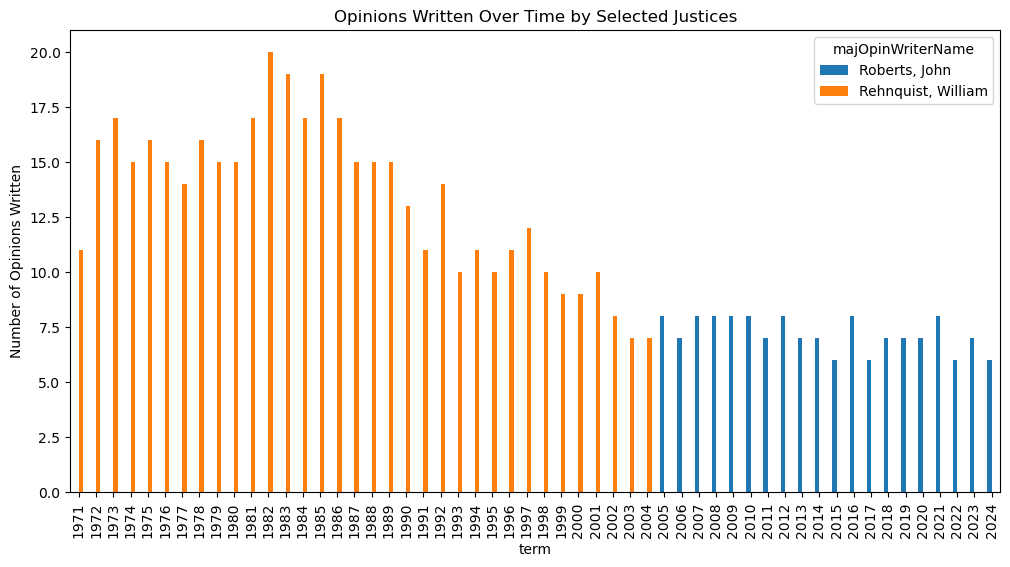

In [11]:
# plot certain justice's opinion writing activity over the years
selected_nonzero.plot(kind="bar", figsize=(12,6))
plt.ylabel("Number of Opinions Written")
plt.title("Opinions Written Over Time by Selected Justices")
plt.show()

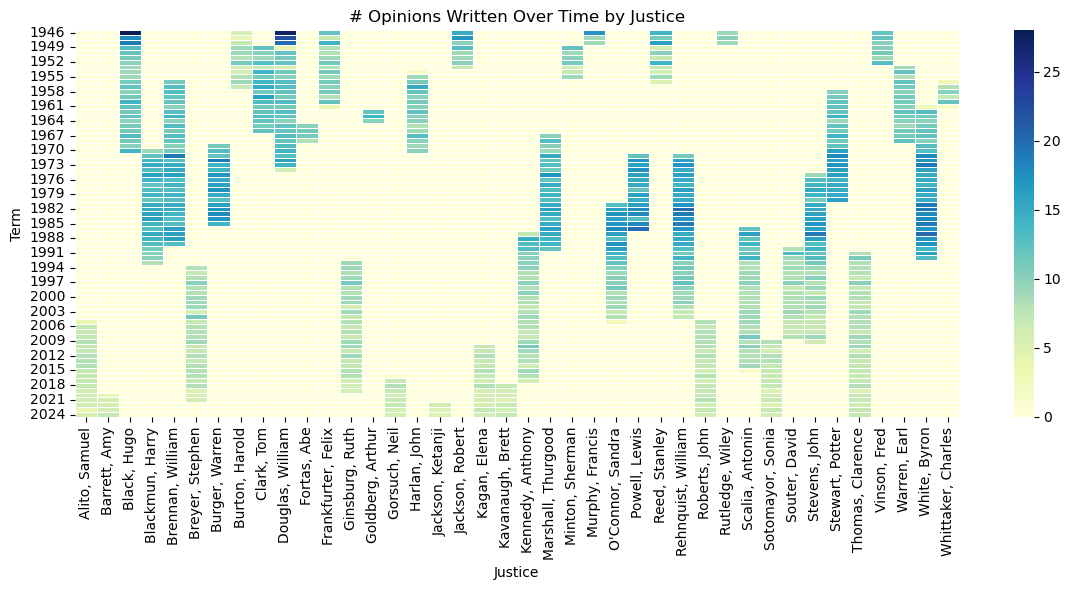

In [12]:
# or keep all the justices and try to visualize who wrote how many in which year in a heat map

# Drop the "Unknown" column first
authorship_over_time_no_unknown = authorship_over_time.drop(columns=["Unknown"])

# Optional: filter for justices with >1 total opinions
filtered_authorship_over_time = authorship_over_time_no_unknown.loc[:, authorship_over_time_no_unknown.sum() > 1]

plt.figure(figsize=(12, 6))
sns.heatmap(filtered_authorship_over_time, cmap="YlGnBu", linewidths=.5)
plt.xlabel("Justice")
plt.ylabel("Term")
plt.title("# Opinions Written Over Time by Justice")

plt.tight_layout()

# Save the plot as a JPEG
plt.savefig('../results/majOpinWriter_workload_vs_year_heatmap.jpg', format='jpg', dpi=300)

plt.show()

In [13]:
# want to know when a particular person is the chief, if there is a justice who often writes majority opinion

c_citations_clean = c_citations.dropna(subset=["chief", "majOpinWriter"])

counts = (
    c_citations_clean
    .groupby(["chief", "majOpinWriterName"])
    .size()
    .reset_index(name="# opinions")
)

# For each Chief, select the top writer

top_writer_by_chief = (
    counts
    .sort_values(["chief", "# opinions"], ascending=[True, False])
    .groupby("chief", as_index=False)
    .first()
)

print(top_writer_by_chief)

dfi.export(
    top_writer_by_chief.style.hide(axis='index'), 
    '../results/tbl_top_majOpinWriters_by_chief.jpg', 
    table_conversion='matplotlib'
)

       chief majOpinWriterName  # opinions
0     Burger      White, Byron         279
1  Rehnquist  O'Connor, Sandra         218
2    Roberts  Thomas, Clarence         145
3     Vinson       Black, Hugo         111
4     Warren  Douglas, William         184
